In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.io import wavfile
import python_speech_features
import re
import IPython.display as ipd
%matplotlib inline

In [2]:
tf.reset_default_graph()

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('./mnist/data/', one_hot = True)

Extracting ./mnist/data/train-images-idx3-ubyte.gz
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz


In [3]:
learning_rate = 0.01
training_epoch = 20
batch_size = 100
n_hidden = 256
n_input = 28 * 28
sample_size = 10

In [4]:
def padding(spectrogram):
    return np.vstack([spectrogram[0, :].reshape(1, -1), spectrogram])

In [7]:
labels = []
train_data=[]
samples_ = []

file_names = []
file_path = []

# train_path 알맞게 바꾸면됨
train_path = '../tf-speech-recognition-challenge/data/train/audio/'

# '클래스이름 'stop에서 바꾸면됨
class_name = 'stop'

for idx, file in enumerate(os.listdir(train_path + class_name + '/')):
    sample, sample_rate = librosa.load(train_path + class_name + '/' + file, sr = 16000)
    spectrogram = python_speech_features.base.logfbank(sample)
    samples_.append(sample)
    while spectrogram.shape[0] < 99:
        spectrogram = padding(spectrogram)
    file_names.append(file)
    
    file_path.append(train_path + class_name + '/' + file)        
    train_data.append(spectrogram)  
    #labels.append(class_name)
    
size = len(train_data)

In [168]:
params = {
    'num_filters': [16, 16, 16, 16, 1],
    'filter_sizes': [7, 7, 7, 7, 7]        
}

def cae(X, activation = tf.nn.sigmoid, is_training = True, reuse = False):
    inputs = X
    W_shapes = []
    L_shapes = []
    
    for i, n_filters, filter_size in zip(np.arange(len(params['num_filters'])), params['num_filters'], params['filter_sizes']):
        shape = inputs.get_shape().as_list()
        L_shapes.append(shape)
        W = tf.Variable(tf.truncated_normal([filter_size, filter_size, shape[-1], n_filters], stddev = 0.1), name='E_Weight'+str(i))
        W_shapes.append([filter_size, filter_size, shape[-1], n_filters])
        b = tf.Variable(tf.truncated_normal([n_filters], stddev = 0.1), name='E_bias'+str(i))
        L = tf.nn.conv2d(inputs, W, strides = [1, 2, 2, 1], padding = 'SAME', name = 'Encoder'+ str(i))
        L = activation(tf.add(L, b))
        L = tf.nn.dropout(L, 0.7)
        inputs = L
        
    for i, n_filters, filter_size, L_shape, W_shape in zip(np.arange(len(params['num_filters'])),
                                                params['num_filters'][::-1],
                                                params['filter_sizes'][::-1],
                                                L_shapes[::-1],
                                                W_shapes[::-1]):
        W = tf.Variable(tf.truncated_normal(W_shape, stddev = 0.1), name='D_Weight'+str(i))
        b = tf.Variable(tf.truncated_normal([W_shape[2]], stddev = 0.1), name='D_bias'+str(i))
        L = tf.nn.conv2d_transpose(inputs,
                                   W,
                                   tf.stack([tf.shape(X)[0], L_shape[1], L_shape[2], L_shape[3]]),
                                   strides = [1, 2, 2, 1],
                                   padding = 'SAME',
                                   name = 'Decoder' + str(i))
        L = activation(tf.add(L, b))
        L = tf.nn.dropout(L, 0.7)
        inputs = L
    return inputs 

In [224]:
device2use='/gpu:0'
tf.reset_default_graph()

In [232]:
# Network Parameters
n_input    = 2574 # MNIST data input (img shape: 28*28)
n_hidden_1 = 1248 # 1st layer num features
n_hidden_2 = 1248 # 2nd layer num features
n_output   = 2574 # 
with tf.device(device2use):
    # tf Graph input
    x = tf.placeholder(tf.float32, [None, n_input])
    y = tf.placeholder(tf.float32, [None, n_output])
    #dropout_keep_prob = tf.placeholder("float")
    # Store layers weight & bias
    weights = {
        'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
        'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
        'out': tf.Variable(tf.random_normal([n_hidden_2, n_output]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden_1])),
        'b2': tf.Variable(tf.random_normal([n_hidden_2])),
        'out': tf.Variable(tf.random_normal([n_output]))
    }
with tf.device(device2use):
    # Create model
    def denoising_autoencoder(_X, _weights, _biases):
        layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(_X, _weights['h1']), _biases['b1'])) 
        layer_1out = tf.nn.dropout(layer_1, 0.7) 
        layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1out, _weights['h2']), _biases['b2'])) 
        layer_2out = tf.nn.dropout(layer_2, 0.8) 
        return tf.nn.sigmoid(tf.matmul(layer_2out, _weights['out']) + _biases['out'])
print ("NETWORK READY")

NETWORK READY


In [233]:
with tf.device(device2use):
    # MODEL
    out = denoising_autoencoder(x, weights, biases)
    # DEFINE LOSS AND OPTIMIZER
    cost = tf.reduce_mean(tf.pow(out-y, 2))
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01).minimize(cost) 
    # INITIALIZE
    init = tf.initialize_all_variables()
print ("FUNCTIONS READY")

FUNCTIONS READY


In [234]:
do_train = 1
sess = tf.Session(config=tf.ConfigProto(
        allow_soft_placement=True, log_device_placement=True))
sess.run(init)

epoch: 0, cost: 21.66767692565918
epoch: 1, cost: 21.969833374023438
epoch: 2, cost: 21.983945846557617
epoch: 3, cost: 21.655559539794922
epoch: 4, cost: 21.602523803710938
epoch: 5, cost: 21.618732452392578
epoch: 6, cost: 21.670244216918945
epoch: 7, cost: 21.626317977905273
epoch: 8, cost: 21.709625244140625
epoch: 9, cost: 21.602344512939453


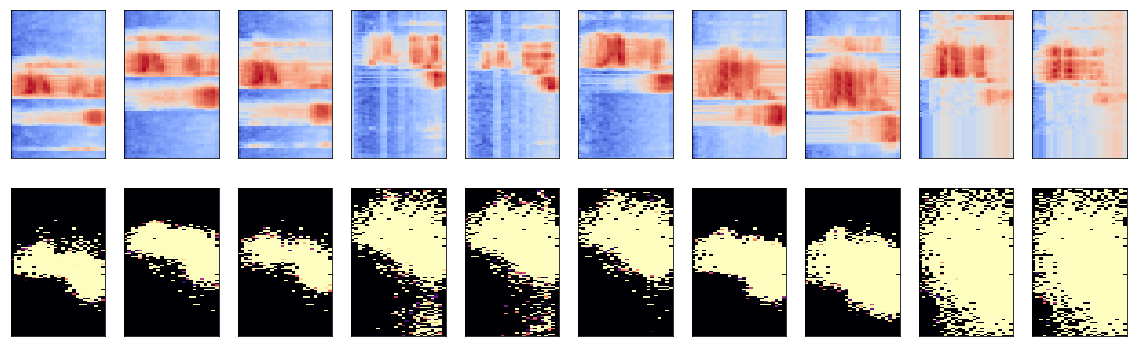

In [238]:

    
for epoch in range(10):
    batches = batch_iter(train_data, 32, True)
    total_cost = []
    for i in batches:
        train_ = np.array([img - mean_img for img in i])
        train_data_noisy = train_ + 0.8 * np.random.randn(train_.shape[0], 2574)
        _, c = sess.run([optimizer, cost], feed_dict = {x: train_data_noisy.reshape(train_.shape[0], -1), y: train_.reshape(train_.shape[0], -1)})
        total_cost.append(c)
    print('epoch: {}, cost: {}'.format(epoch, np.mean(total_cost)))
    
mean_img = np.mean(train_data[10:20])
test = np.array([img - mean_img for img in train_data[10:20]])
test_noisy = test + 0.8 *np.random.randn(test.shape[0], 2574)                 

samples = sess.run(out, feed_dict = {x: test.reshape(10, -1)})
fig = plt.figure(figsize= (20, 6))
for i in range(20):
    ax = fig.add_subplot(2, 10, i + 1)
    if i < 10:
        librosa.display.specshow(np.reshape(test[i], (99, 26)))
    else:
        librosa.display.specshow(np.reshape(samples[i-10], (99, 26)))
plt.show()

In [183]:


tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, 99, 26, 1])
Y = tf.placeholder(tf.float32, [None, 99, 26, 1])
construct = cae(X, activation = tf.nn.leaky_relu)
cost = tf.reduce_mean(tf.pow(construct- Y, 2))
train = tf.train.AdamOptimizer(3e-4).minimize(cost)

for v in tf.trainable_variables():
    print(v) 

<tf.Variable 'E_Weight0:0' shape=(7, 7, 1, 16) dtype=float32_ref>
<tf.Variable 'E_bias0:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'E_Weight1:0' shape=(7, 7, 16, 16) dtype=float32_ref>
<tf.Variable 'E_bias1:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'E_Weight2:0' shape=(7, 7, 16, 16) dtype=float32_ref>
<tf.Variable 'E_bias2:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'E_Weight3:0' shape=(7, 7, 16, 16) dtype=float32_ref>
<tf.Variable 'E_bias3:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'E_Weight4:0' shape=(7, 7, 16, 1) dtype=float32_ref>
<tf.Variable 'E_bias4:0' shape=(1,) dtype=float32_ref>
<tf.Variable 'D_Weight0:0' shape=(7, 7, 16, 1) dtype=float32_ref>
<tf.Variable 'D_bias0:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'D_Weight1:0' shape=(7, 7, 16, 16) dtype=float32_ref>
<tf.Variable 'D_bias1:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'D_Weight2:0' shape=(7, 7, 16, 16) dtype=float32_ref>
<tf.Variable 'D_bias2:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'D_Weig

In [184]:
batch_size = 32
sample_size = 10

In [185]:
train_data = np.array(train_data)

In [186]:
train_data.reshape(train_data.shape[0], -1).shape

(2342, 2574)

In [187]:
train_data = train_data.reshape(train_data.shape[0], -1)

In [188]:
train_data[:10].shape

(10, 2574)

In [189]:
30 * np.random.randn(train_data.shape[0], 2574)

array([[ 23.19500887, -37.42939502, -37.78949359, ..., -42.79544509,
         17.97003659, -12.14653365],
       [ 55.8735133 ,  14.3507991 ,   1.04886374, ...,  13.83884544,
        -44.94375044, -12.26648656],
       [ 40.37666815, -36.3812914 , -40.52465641, ...,  28.20288788,
        -74.56320382, -10.22701458],
       ..., 
       [ 13.4478775 ,  -0.83165935,  24.99328516, ..., -46.82913638,
        -28.72164809, -47.15149337],
       [ 27.86988307,   6.09054836, -20.48006962, ..., -18.13938204,
        -37.87684291,  55.26973744],
       [-17.94358936,  22.2288524 ,  44.32277014, ...,  -7.33097224,
          4.82003585,  -5.92623875]])

In [190]:
def batch_iter(x, batch_size, shuffle = True):
    x = np.array(x)
    data_size = len(x)
    # 각 epoch 마다 batch숫자
    num_batches_per_epoch = int((data_size) / batch_size) + 1
    if shuffle:
        # 각 epoch마다 shuffle
        shuffle_mask = np.random.permutation(np.arange(data_size))
        x = x[shuffle_mask]
    for i in range(num_batches_per_epoch):
        start_idx = i * batch_size     
        # start_idx가 data_size와 같으면 종료
        if start_idx == data_size:
            return
        end_idx = min((i + 1) * batch_size, data_size)
        yield x[start_idx: end_idx]

In [191]:
mean_img = np.mean(train_data, axis = 0)

In [178]:
mean_img

array([-17.62393969, -16.79438592, -16.36153142, ..., -13.6235354 ,
       -13.77485312, -14.70972769])

In [179]:
train

<tf.Operation 'Adam' type=NoOp>

In [180]:
train_data_noisy.reshape(-1, 99, 26, 1).shape

(6, 99, 26, 1)

epoch: 0, cost: 23.226512908935547
epoch: 1, cost: 22.847946166992188
epoch: 2, cost: 19.30377197265625
epoch: 3, cost: 17.09050941467285
epoch: 4, cost: 16.47161102294922
epoch: 5, cost: 16.126285552978516
epoch: 6, cost: 15.865082740783691
epoch: 7, cost: 15.70688247680664
epoch: 8, cost: 15.29907512664795
epoch: 9, cost: 15.428717613220215


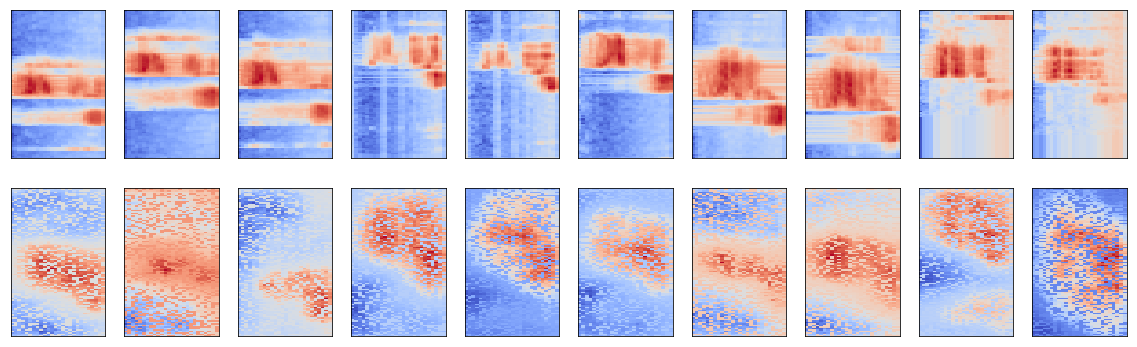

In [209]:
mean_img = np.mean(train_data)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    for epoch in range(10):
        batches = batch_iter(train_data, 32, True)
        total_cost = []
        for i in batches:
            train_ = np.array([img - mean_img for img in i])
            train_data_noisy = train_ + 0.8 * np.random.randn(train_.shape[0], 2574)
            _, c = sess.run([train, cost], feed_dict = {X: train_data_noisy.reshape(-1, 99, 26, 1), Y: train_.reshape(-1, 99, 26, 1)})
            total_cost.append(c)
        print('epoch: {}, cost: {}'.format(epoch, np.mean(total_cost)))
        
    mean_img = np.mean(train_data[10:20])
    test = np.array([img - mean_img for img in train_data[10:20]])
    test_noisy = test + 0.8 *np.random.randn(test.shape[0], 2574)                 
    
    samples = sess.run(construct, feed_dict = {X: test.reshape(-1, 99, 26, 1)})
    fig = plt.figure(figsize= (20, 6))
    for i in range(20):
        ax = fig.add_subplot(2, 10, i + 1)
        if i < 10:
            librosa.display.specshow(np.reshape(test[i], (99, 26)))
        else:
            librosa.display.specshow(np.reshape(samples[i-10], (99, 26)))

    plt.show()
    

In [210]:
samples.shape

(10, 99, 26, 1)

In [124]:
test = train_data[:]
test_noisy = test + 0.8 * np.random.randn(test.shape[0], 2574) 

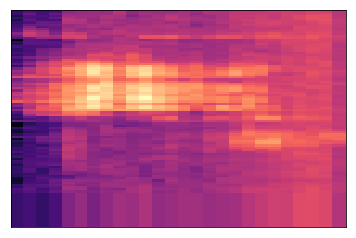

In [200]:
librosa.display.specshow(test[9].reshape(99, 26))

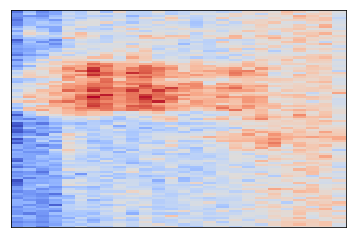

In [207]:
librosa.display.specshow(test_noisy[9].reshape(99, 26))

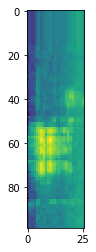

In [202]:
plt.imshow(test[9].reshape(99, 26))

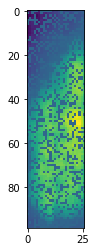

In [203]:
plt.imshow(samples[9].squeeze())

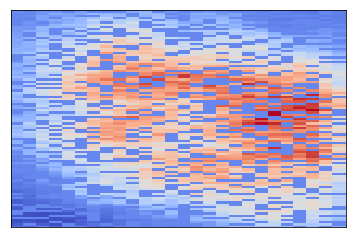

In [213]:
librosa.display.specshow(samples[9].squeeze())

In [41]:
        
with tf.Session() as sess:
    test = np.array([img -mean_img for img in mnist.train.images[:sample_size]])
    test_noisy = test + 0.3*np.random.randn(test.shape[0], 784)     
    
    samples = sess.run(construct, feed_dict = {X: test_noisy.reshape(-1, 28, 28, 1)})
    fig, axes = plt.subplots(2, sample_size, figsize = (sample_size, 2))
    for i in range(sample_size):        
        axes[0][i].set_axis_off()
        axes[0][i].imshow(np.reshape(test_noisy[i], (28, 28)))
        
        axes[1][i].set_axis_off()
        axes[1][i].imshow(np.reshape(samples[i], (28, 28)))
    plt.show()

IndentationError: expected an indented block (<ipython-input-41-cd0922a8fe85>, line 9)